#**Аналіз на чутливість**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, mean_squared_error, make_scorer, r2_score
import random
from scipy.stats import kruskal
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [3]:
df = pd.read_csv('/content/drive/MyDrive/d/vika2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           25 non-null     object 
 1   Index                             25 non-null     float64
 2   GDP ($ per capita)                25 non-null     float64
 3   workersQUANT                      25 non-null     float64
 4   budget_for_research_science       25 non-null     float64
 5   workersQUANT2                     25 non-null     float64
 6   researchers_high_edu_sector       25 non-null     float64
 7   science_conf_budg_for_one         25 non-null     float64
 8   Happy Index                       25 non-null     float64
 9   Human Index                       25 non-null     float64
 10  NPAT                              25 non-null     float64
 11  NPLAYER_RD                        25 non-null     float64
 12  NFIRM_RD  

In [4]:
#del df['Population']
del df['GDP ($ per capita)']
#del df['weigh_money_in_dif_area_research']
#del df['NPAT_AVG_F']
#del df['Gov expend res % gdp']

In [5]:
df.rename(columns={'Index': 'Average'}, inplace=True)

In [6]:
df1 = df.copy()
df1['Average'] = df1.mean(axis=1)
min_value = df1['Average'].min()
max_value = df1['Average'].max()
df1['Average'] = (df1['Average'] - min_value) / (max_value - min_value)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           25 non-null     object 
 1   Average                           25 non-null     float64
 2   workersQUANT                      25 non-null     float64
 3   budget_for_research_science       25 non-null     float64
 4   workersQUANT2                     25 non-null     float64
 5   researchers_high_edu_sector       25 non-null     float64
 6   science_conf_budg_for_one         25 non-null     float64
 7   Happy Index                       25 non-null     float64
 8   Human Index                       25 non-null     float64
 9   NPAT                              25 non-null     float64
 10  NPLAYER_RD                        25 non-null     float64
 11  NFIRM_RD                          25 non-null     float64
 12  NRES_RD   

<ipython-input-6-7c8782aec006>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df1['Average'] = df1.mean(axis=1)


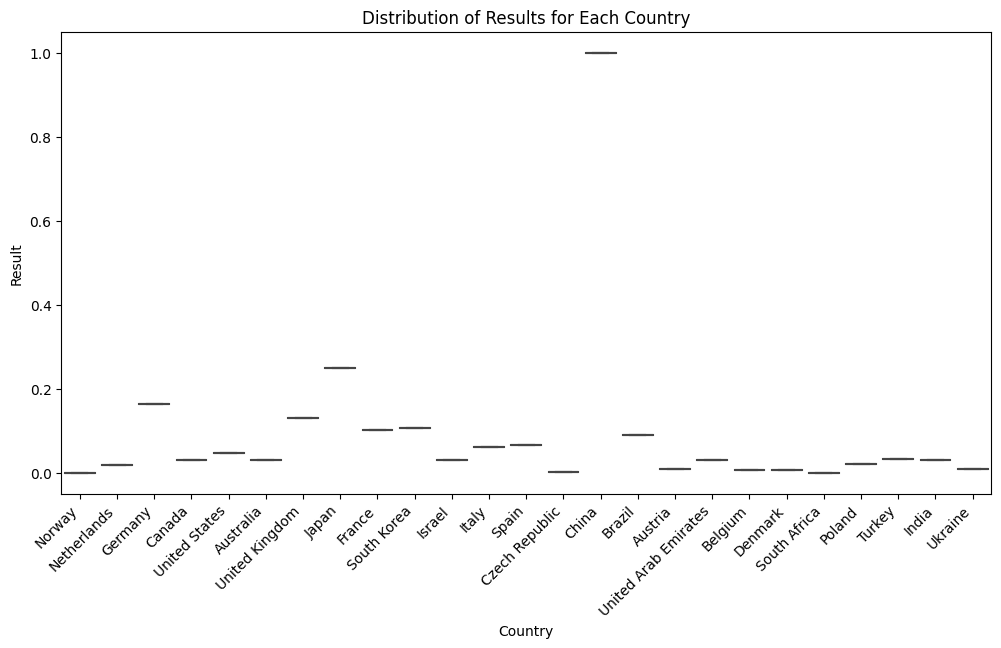

In [7]:
gh = df1.copy()
plt.figure(figsize=(12, 6))
sns.boxplot(x='Country', y='Average', data=gh)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Country')
plt.ylabel('Result')
plt.title('Distribution of Results for Each Country')
plt.show()

##**Пошук важливих ознак**

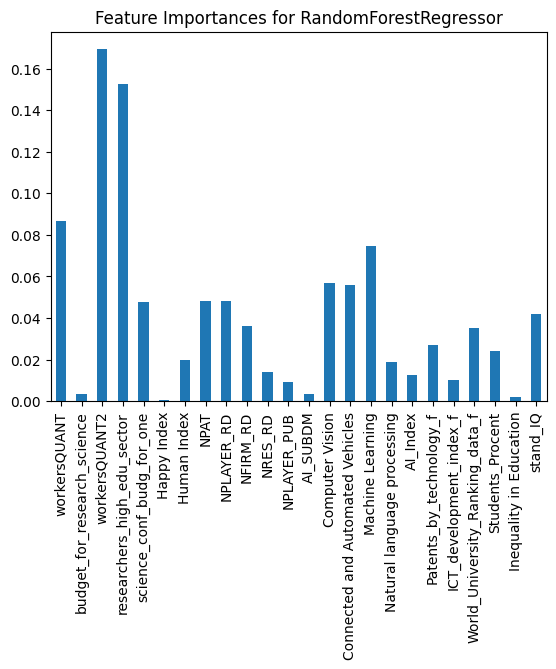

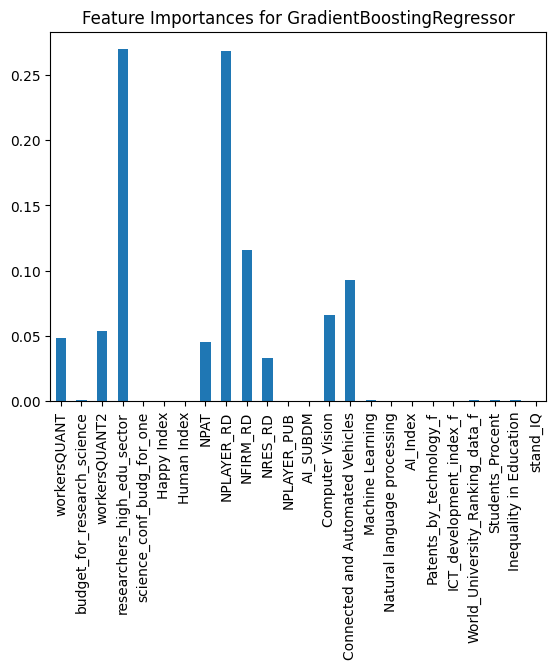

In [8]:
outcome_variable = 'Average'
l = df1.copy()
features_of_interest = l.drop(['Country', outcome_variable], axis=1).columns
X_train, X_test, y_train, y_test = train_test_split(l[features_of_interest], l[outcome_variable], test_size=0.2, random_state=42)

models = [
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

for model in models:
    model.fit(X_train, y_train)
    feature_importances = pd.Series(model.feature_importances_, index=features_of_interest)
    title = f'Feature Importances for {model.__class__.__name__}'
    feature_importances.plot(kind='bar')
    plt.title(title)
    plt.show()

In [9]:
#статистичний тест (Kruskal-Wallis) для порівняння між різними групами
for feature in features_of_interest:
    groups = [df1[df1[feature] == value][outcome_variable] for value in df1[feature].unique()]
    stat, p_value = kruskal(*groups)
    print(f"Kruskal-Wallis Test for {feature}: Statistic = {stat}, P-value = {p_value}")


Kruskal-Wallis Test for workersQUANT: Statistic = 17.377342657342666, P-value = 0.2366263160203075
Kruskal-Wallis Test for budget_for_research_science: Statistic = 20.772923076923078, P-value = 0.41060489345737455
Kruskal-Wallis Test for workersQUANT2: Statistic = 23.483076923076936, P-value = 0.1727026666830069
Kruskal-Wallis Test for researchers_high_edu_sector: Statistic = 23.272087912087926, P-value = 0.1803497684196926
Kruskal-Wallis Test for science_conf_budg_for_one: Statistic = 24.000000000000014, P-value = 0.4615973330636175
Kruskal-Wallis Test for Happy Index: Statistic = 22.67076923076924, P-value = 0.48012797482478886
Kruskal-Wallis Test for Human Index: Statistic = 24.000000000000014, P-value = 0.4615973330636175
Kruskal-Wallis Test for NPAT: Statistic = 24.000000000000014, P-value = 0.4615973330636175
Kruskal-Wallis Test for NPLAYER_RD: Statistic = 24.000000000000014, P-value = 0.4615973330636175
Kruskal-Wallis Test for NFIRM_RD: Statistic = 21.507692307692324, P-value = 

##**Аналіз впливу окремих спостережень**

Partial dependence plots (PDPs) показують взаємозв'язок між окремою ознакою та передбаченою величиною, при цьому інші ознаки залишаються незмінними. Кожен графік у сітці представляє часткову залежність передбаченої величини від конкретної ознаки.

Ось, що можна зрозуміти з графіків PDP:

+ **Напрямок впливу:**

Якщо лінія на графіку спрямована вгору, це вказує на позитивний зв'язок. Збільшення значення ознаки пов'язано зі збільшенням передбаченої величини.
Якщо лінія спрямована вниз, це вказує на від'ємний зв'язок. Збільшення значення ознаки пов'язано зі зменшенням передбаченої величини.

+ **Величина впливу:**

Чим крутіше нахил лінії на графіку, тим сильніший вплив має ознака на передбачену величину. Крутіший нахил вказує на більший вплив.

+ **Нелінійні відносини:**

Графіки PDP можуть відобразити нелінійні відносини між ознаками та передбаченнями. Форма кривої може розкривати більш складні шаблони, такі як пороги чи взаємодії.

+ **Взаємодії між ознаками:**

Якщо графіки PDP вказують на взаємодії між двома ознаками, це означає, що вплив однієї ознаки на передбачення залежить від значення іншої ознаки.

+ **Важливість ознак:**

Графіки PDP можуть допомогти визначити, які ознаки мають найбільший вплив на передбачення моделі. Ознаки з більшими змінами передбаченої величини у своєму діапазоні є більш впливовими.
Важливо пам'ятати, що графіки PDP надають середній погляд на взаємозв'язок і базуються на припущенні, що інші ознаки залишаються незмінними. Вони корисні для отримання уявлення про поведінку моделі та розуміння того, як окремі ознаки сприяють передбаченням.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439:

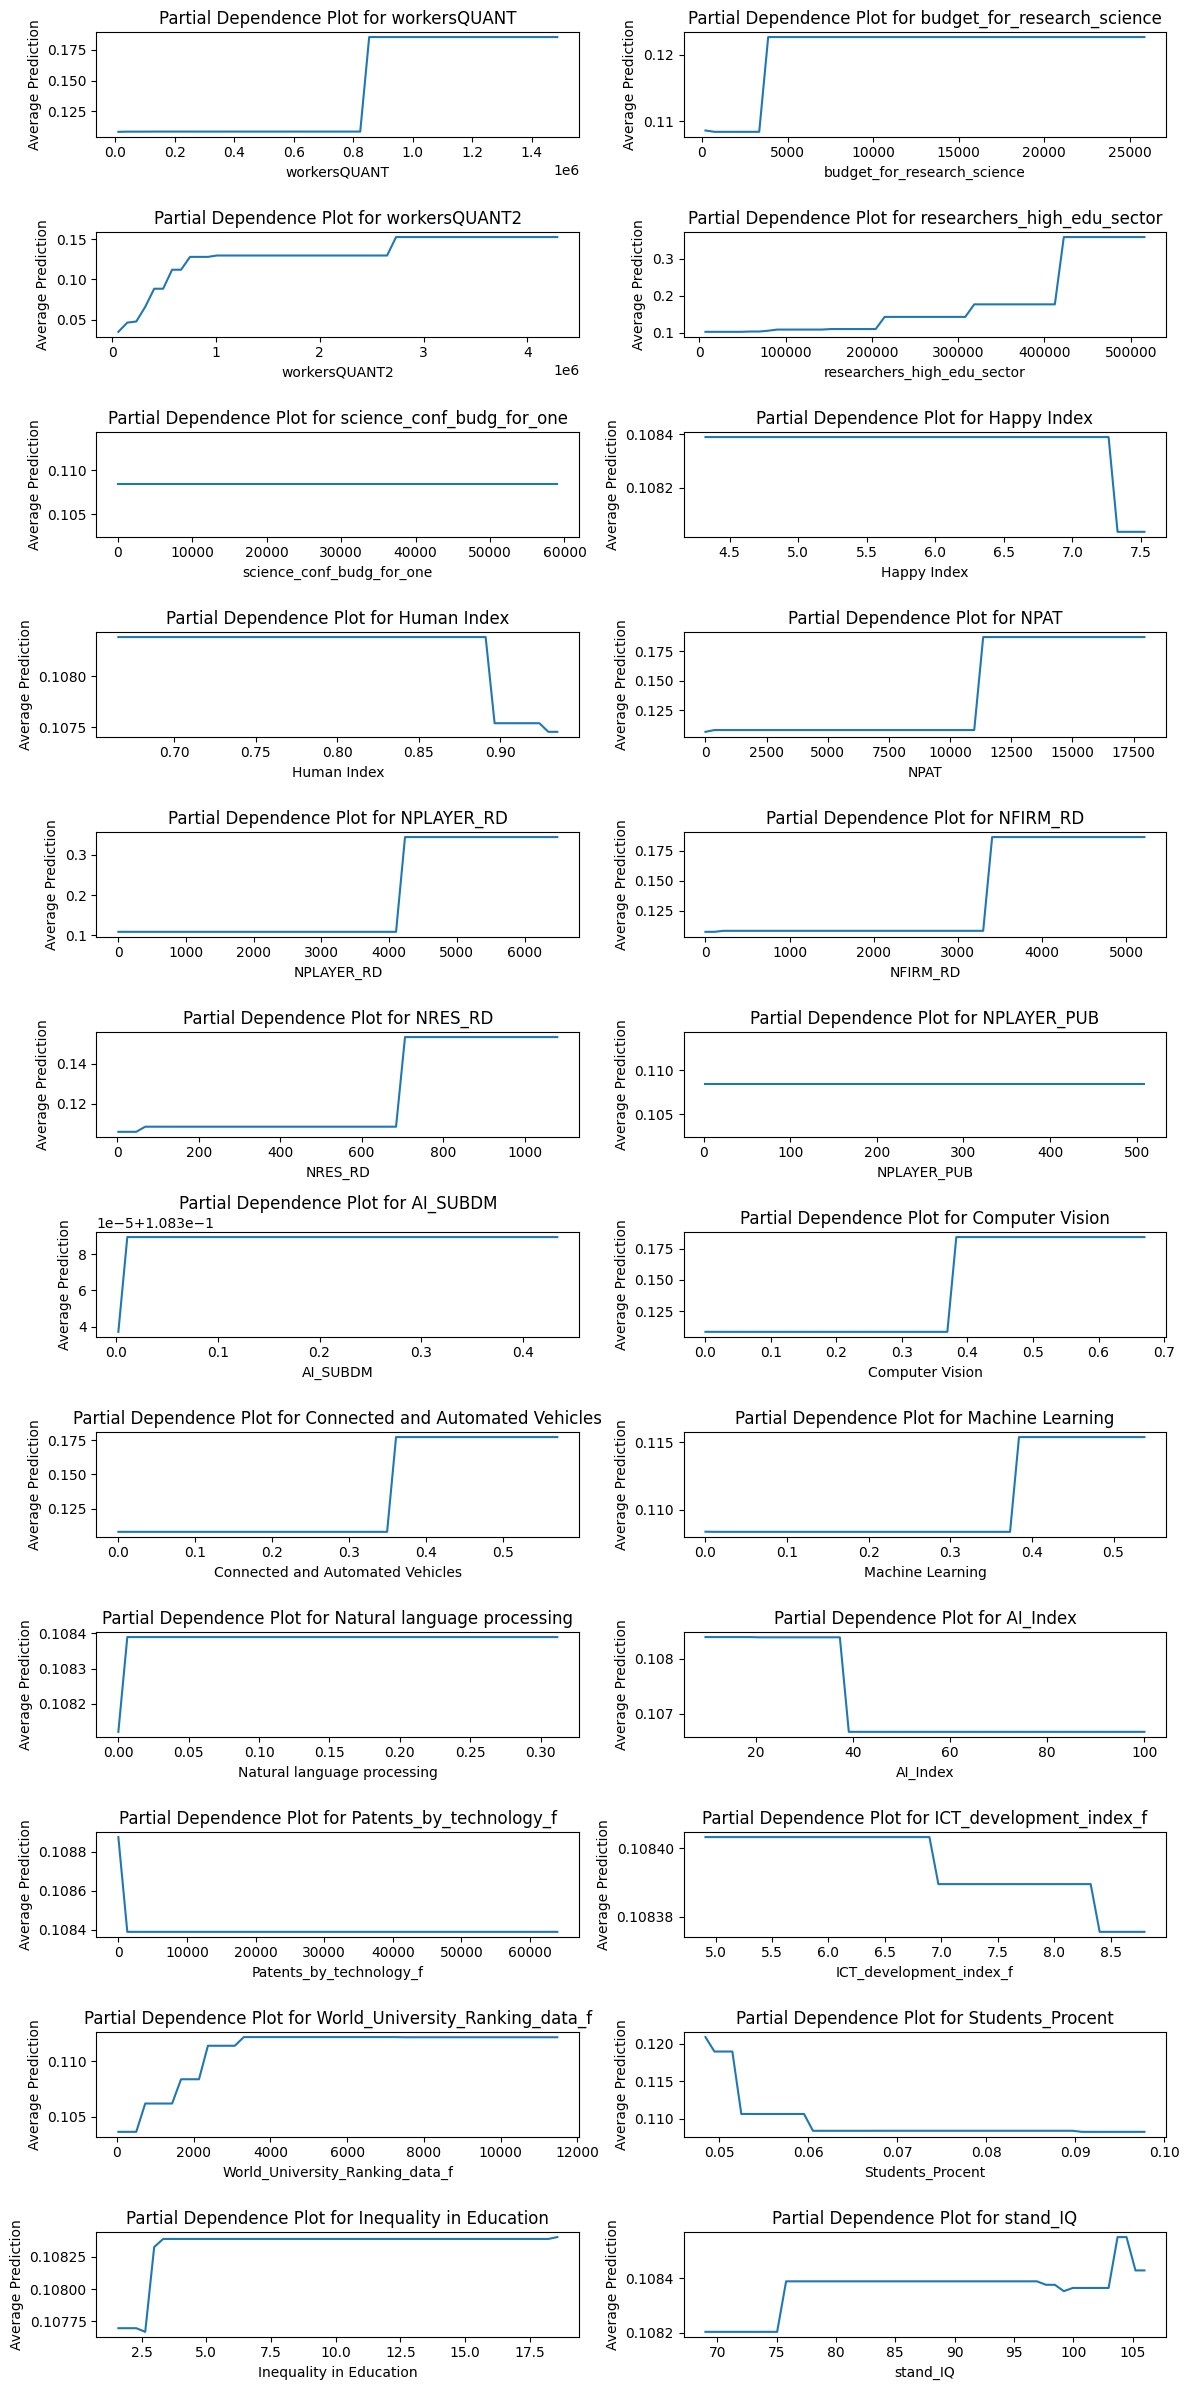

In [10]:
n_rows = len(features_of_interest) // 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))
axes = axes.flatten()

for i, feature_name in enumerate(features_of_interest):
    feature_range = np.linspace(X_train[feature_name].min(), X_train[feature_name].max(), num=50)
    pdp_values = np.zeros_like(feature_range)

    for j, val in enumerate(feature_range):
        X_temp = X_train.copy()
        X_temp[feature_name] = val
        pdp_values[j] = model.predict(X_temp.mean().values.reshape(1, -1))

    axes[i].plot(feature_range, pdp_values)
    axes[i].set_title(f'Partial Dependence Plot for {feature_name}')
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('Average Prediction')

plt.tight_layout()
plt.show()


##**Перевірка стійкості моделі**

Оцінка моделі на тестових даних:

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 2.388739852994882e-05
R-squared: 0.9827675337513426


  **Стійкість до змін**, збільшимо значення кожної ознаки в 10% почергово та подивимось відповідні результати

In [12]:
for i in range(len(features_of_interest)):
    X_test_modified = X_test.copy()
    X_test_modified.iloc[:, i] = 1.1 * X_test_modified.iloc[:, i]

    y_pred_modified = model.predict(X_test_modified)

    mse_modified = mean_squared_error(y_test, y_pred_modified)
    r2_modified = r2_score(y_test, y_pred_modified)
    print(f'Name of column: {X_test_modified.columns[i]}')
    print(f'Mean Squared Error (Modified): {mse_modified}')
    print(f'R-squared (Modified): {r2_modified}')
    print("\n\n")


Name of column: workersQUANT
Mean Squared Error (Modified): 2.576684482671686e-05
R-squared (Modified): 0.9814116935649526



Name of column: budget_for_research_science
Mean Squared Error (Modified): 2.3838324143496252e-05
R-squared (Modified): 0.9828029362129023



Name of column: workersQUANT2
Mean Squared Error (Modified): 3.8739497530111425e-05
R-squared (Modified): 0.9720531692540476



Name of column: researchers_high_edu_sector
Mean Squared Error (Modified): 2.3969052688640757e-05
R-squared (Modified): 0.9827086281098615



Name of column: science_conf_budg_for_one
Mean Squared Error (Modified): 2.388739852994882e-05
R-squared (Modified): 0.9827675337513426



Name of column: Happy Index
Mean Squared Error (Modified): 2.388739852994882e-05
R-squared (Modified): 0.9827675337513426



Name of column: Human Index
Mean Squared Error (Modified): 2.3752885960696048e-05
R-squared (Modified): 0.982864571664733



Name of column: NPAT
Mean Squared Error (Modified): 2.388739852994882e-05

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439:

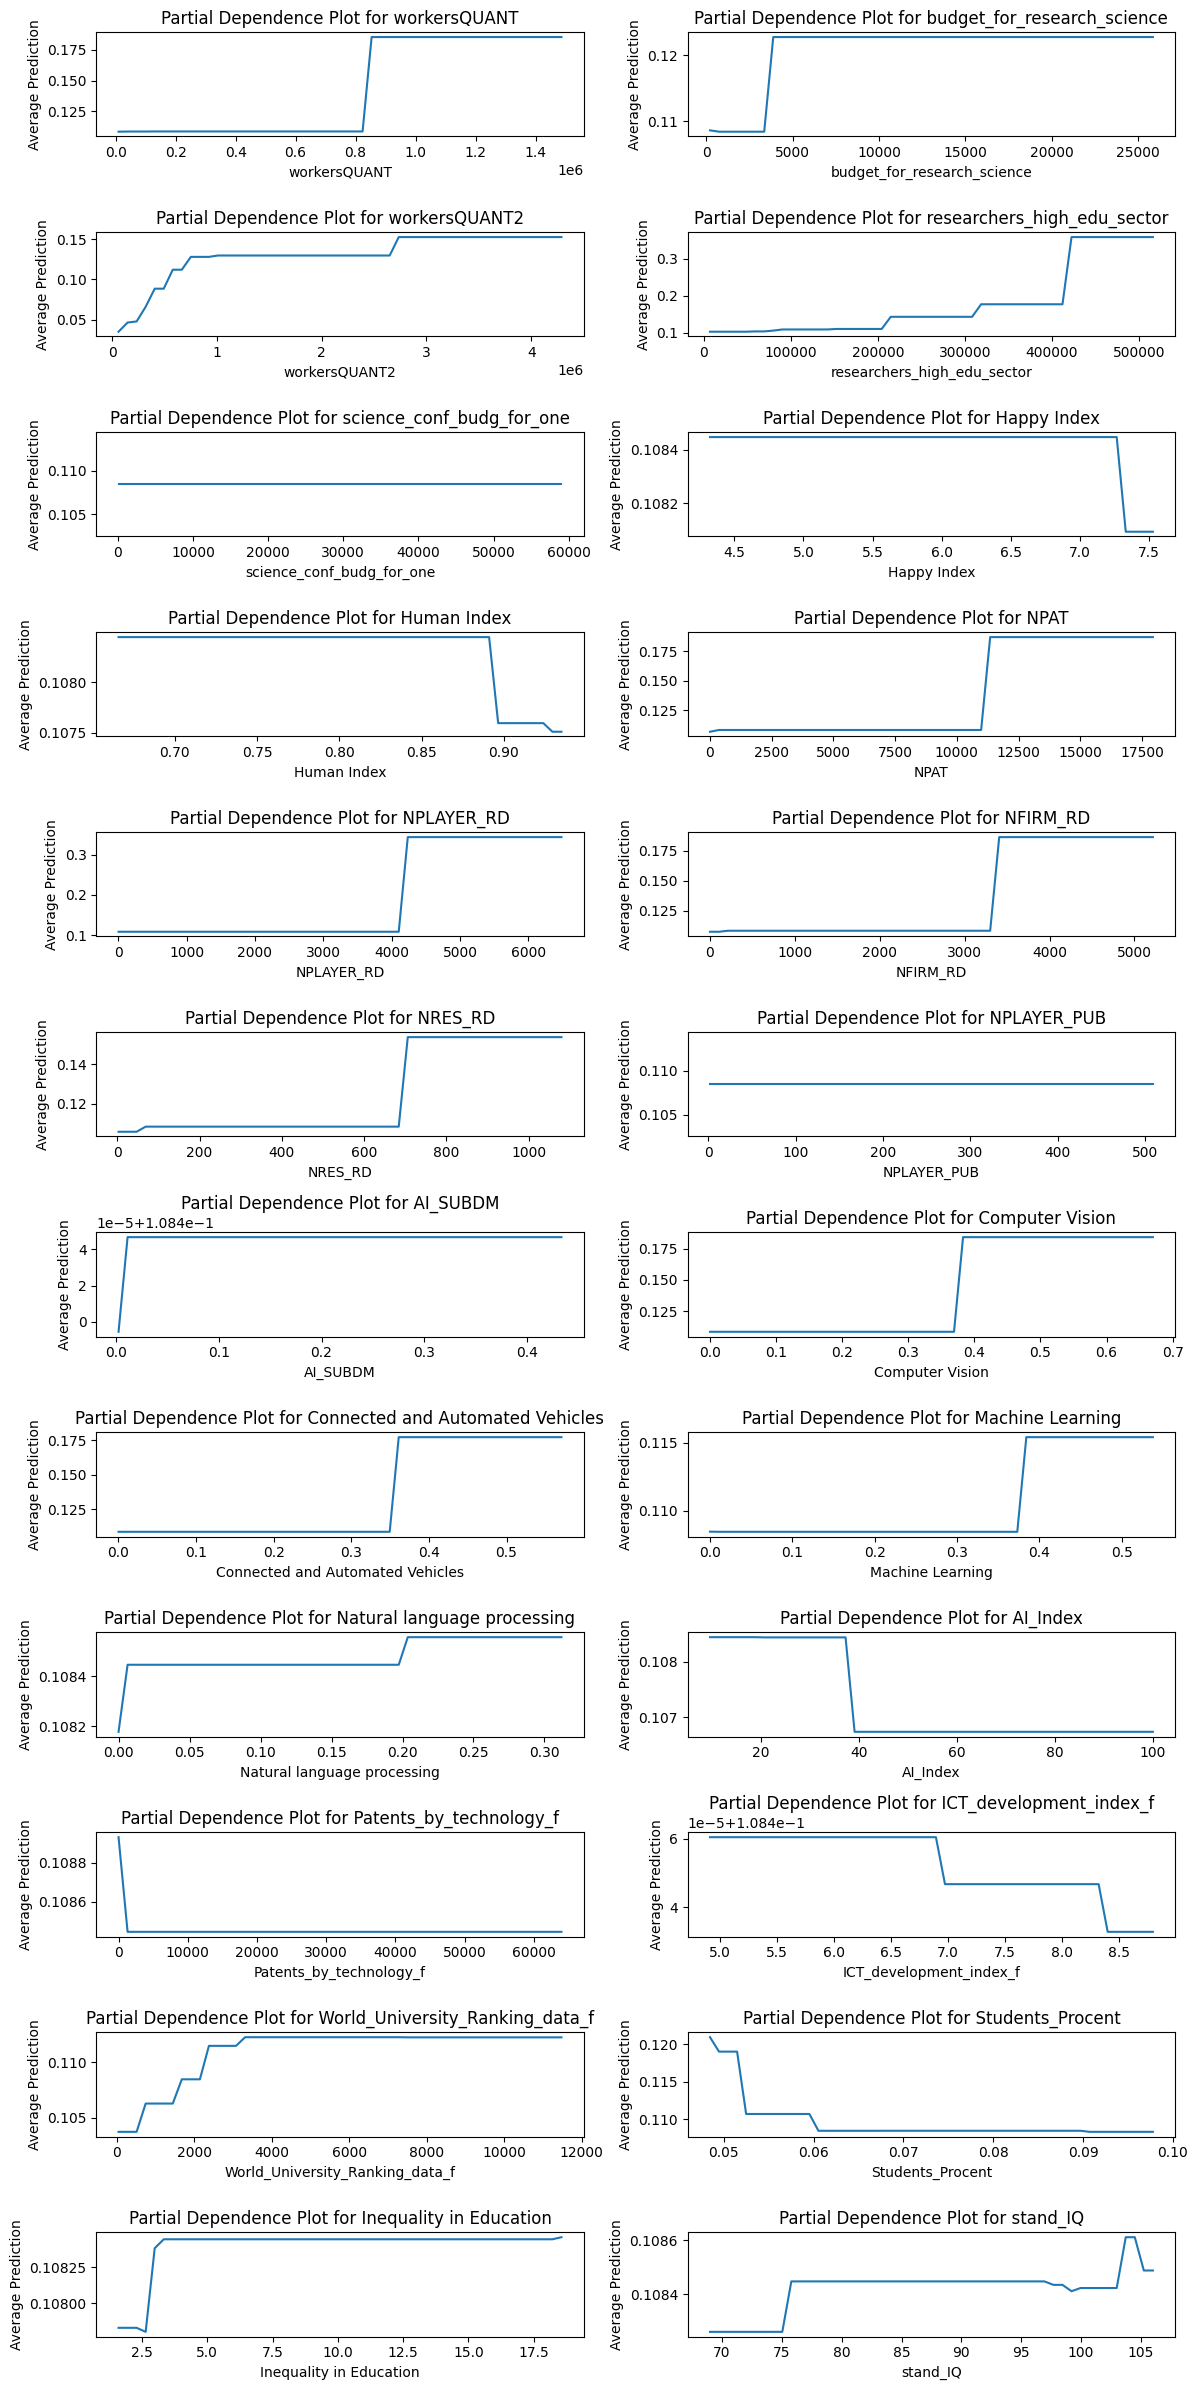

In [13]:
n_rows = len(features_of_interest) // 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))
axes = axes.flatten()

for i, feature_name in enumerate(features_of_interest):
    feature_range = np.linspace(X_train[feature_name].min(), X_train[feature_name].max(), num=50)
    pdp_values = np.zeros_like(feature_range)

    for j, val in enumerate(feature_range):
        X_temp = X_train.copy()
        X_temp.iloc[:, 0] = 1.1 * X_temp.iloc[:, 0]
        X_temp[feature_name] = val
        pdp_values[j] = model.predict(X_temp.mean().values.reshape(1, -1))

    axes[i].plot(feature_range, pdp_values)
    axes[i].set_title(f'Partial Dependence Plot for {feature_name}')
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('Average Prediction')

plt.tight_layout()
plt.show()


##**Аналіз впливу гіперпараметрів**

здійснемо рандомне задання відповідних параметрів, задамо метрику для оцінки та здійснимо відповідний пошук

In [14]:
#rand
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf_model = RandomForestRegressor()
scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Найкращі гіперпараметри:", grid_search.best_params_)
print("Найкращий показник (MSE) на тренувальному наборі:", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'Mean Squared Error (Test): {mse_test}')
print(f'R-squared (Test): {r2_test}')


Найкращі гіперпараметри: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Найкращий показник (MSE) на тренувальному наборі: 0.03831075663402979
Mean Squared Error (Test): 0.00021608062675546863
R-squared (Test): 0.8441185588759746


##**Графіки чутливості та специфічності**

план-капкан по ауку, або я намагалась

<function matplotlib.pyplot.show(close=None, block=None)>

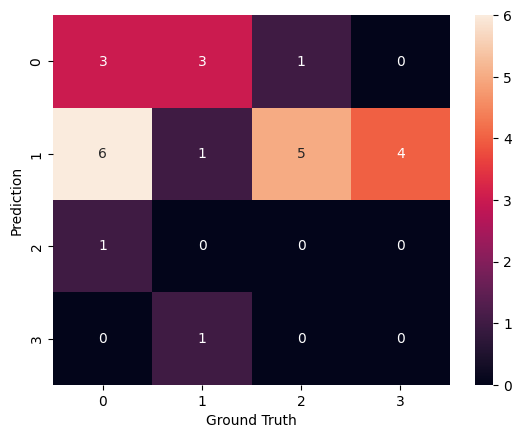

In [22]:
from sklearn.metrics import classification_report,confusion_matrix
cm = confusion_matrix(true_lab, labels)
plot = sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show

Аналіз впливу гіперпараметрів:

Модифікуйте значення гіперпараметрів моделі та спостерігайте за змінами в її результаті.
Використовуйте крос-валідацію для оцінки впливу гіперпараметрів на стійкість моделі.
Аналіз викидів:

Визначте викиди в даних та досліджуйте, як вони впливають на модель.
Використовуйте методи для виявлення викидів та розглядайте їх вплив.
Криві чутливості та специфічності:

Розглядайте криві чутливості та специфічності для моделі класифікації.
Змінюйте пороги вирішення і досліджуйте, як це впливає на результати.
Криві ROC та AUC:

Використовуйте криві ROC та площу під ними (AUC) для оцінки моделі класифікації.
Валідація на зовнішніх даних:

Використовуйте додаткові зовнішні дані для перевірки стійкості та чутливості моделі.

##**Додаткові зовнішні**

я чекаю на екстьорнал датасет

#### rhs

In [23]:
external_data = pd.read_csv('/content/drive/MyDrive/externalds.csv')
external_data['Average'] = [0.08,0.06, 0.08,0.99,0.19,0.38]
external_data

,Country,Net migration,Electricity per person,workersQUANT,budget_for_research_science,workersQUANT2,researchers_high_edu_sector,researchers_priv_nonprof_sector,science_conf_budg_for_one,Happy Index,...,Machine Learning,Natural language processing,AI_Index,Patents_by_technology_f,ICT_development_index_f,World_University_Ranking_data_f,Students_Procent,Inequality in Education,stand_IQ,Average
0,Estonia,-3.16,0.009194,1435.733645,32.711177,10119.600000,4682.000000,1.155000e+02,51.50,5.517,...,0.000156,0.000646,26.600,3.186581,8.16,89.62,0.065649,2.374725,100.00,0.08
1,Finland,0.95,0.013142,10256.143872,220.107120,79717.149600,22550.415200,6.134000e+02,890.00,7.413,...,0.002212,0.001912,31.360,161.600427,7.83,910.63,0.063197,1.991805,101.00,0.06
2,Latvia,-2.23,0.002825,1961.565619,31.282024,9910.600000,5324.200000,1.658942e+07,7.20,5.560,...,0.001560,0.000000,25.658,1.569326,6.90,573.93,0.067080,3.762068,94.79,0.08
3,Lithuania,-0.71,0.001190,4564.491071,36.434402,20928.200000,12571.600000,4.628331e+06,35.85,5.813,...,0.001560,0.000000,19.590,2.111472,6.97,88.71,0.073850,5.084202,95.00,0.99
4,Portugal,3.57,0.005684,13622.234234,152.187491,92570.000000,48649.000000,5.900000e+03,611.10,5.123,...,0.001358,0.000969,20.890,100.135388,6.88,631.33,0.053084,12.954015,93.00,0.19
5,Sweden,1.67,0.017303,27921.107143,413.115426,125254.333333,40438.333333,2.676667e+02,2183.45,7.291,...,0.002513,0.002793,29.850,332.209135,8.41,1149.36,0.071032,3.549543,98.00,0.38


#### jk

In [24]:
external_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           6 non-null      object 
 1   Net migration                     6 non-null      float64
 2   Electricity per person            6 non-null      float64
 3   workersQUANT                      6 non-null      float64
 4   budget_for_research_science       6 non-null      float64
 5   workersQUANT2                     6 non-null      float64
 6   researchers_high_edu_sector       6 non-null      float64
 7   researchers_priv_nonprof_sector   6 non-null      float64
 8   science_conf_budg_for_one         6 non-null      float64
 9   Happy Index                       6 non-null      float64
 10  Human Index                       6 non-null      float64
 11  NPAT                              6 non-null      float64
 12  NPAT_AVG_PL 

In [25]:
del external_data['Net migration']
del external_data['NPAT_AVG_PL']
del external_data['Electricity per person']
del external_data['researchers_priv_nonprof_sector']
#del df['Gov expend res % gdp']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop(['Country', 'Average'], axis=1), df1['Average'], test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse_original = mean_squared_error(y_test, y_pred)
r2_original = r2_score(y_test, y_pred)
#print(y_pred)
print(f'Mean Squared Error (Original): {mse_original}')
print(f'R-squared (Original): {r2_original}')

X_external = external_data.drop(['Country', 'Average'], axis=1)
y_external = external_data['Average']

y_pred_external = model.predict(X_external)
mse_external = mean_squared_error(y_external, y_pred_external)
r2_external = r2_score(y_external, y_pred_external)

print(f'Mean Squared Error (External): {mse_external}')
print(f'R-squared (External): {r2_external}')


Mean Squared Error (Original): 0.0007617724696003446
R-squared (Original): 0.4504542487083274
Mean Squared Error (External): 0.18187704683482195
R-squared (External): -0.681624636853706
